# **手写数字识别器--认识卷积神经网络**

当我们熟悉了神经网络如何解决预测与分类问题这些基础知识以后，便可以开始学习第一个真正意义上的深度网络了，这就是卷积神经网络(convolutional neural network，CNN)。

以卷积神经网络作为基础架构，我们不仅可以解决图像分类这样的传统问题，而且可以让计算机对图像进行一定程度的理解，这极大地推动了人工智能的发展。比如图像的语义分割(semantic segmentation)，目的是确定一张图片中的不同实体，再划分不同实体之间的边界，并给各个实体加以标注。一些有趣的应用还可以让机器看图说话(image captioning)——通过卷积神经网络将图像处理成一个隐含向量的编码，再用循环神经网络解读这段编码。

卷积神经网络之所以突然获得如此成功，是因为它能够自动从数据中提取特征。在此之前的网络结构都依赖设计人员的精力和经验。卷积神经网络的突破在与它可以将整个特征工程自动化：无须实验人员的参与，就能自动从数据中学习出识别模板。


**本文将围绕手写数字识别这一内容，介绍卷积神经网络的工作原理。会使用pytorch来实现一个卷积神经网络，完成手写数字识别任务。在此基础上，引出过滤器、特征匹配与特征图的概念，揭示卷积神经网络的工作原理。**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1.什么是卷积神经网络**

首先，从直观上认识一下卷积神经网络，如下图：

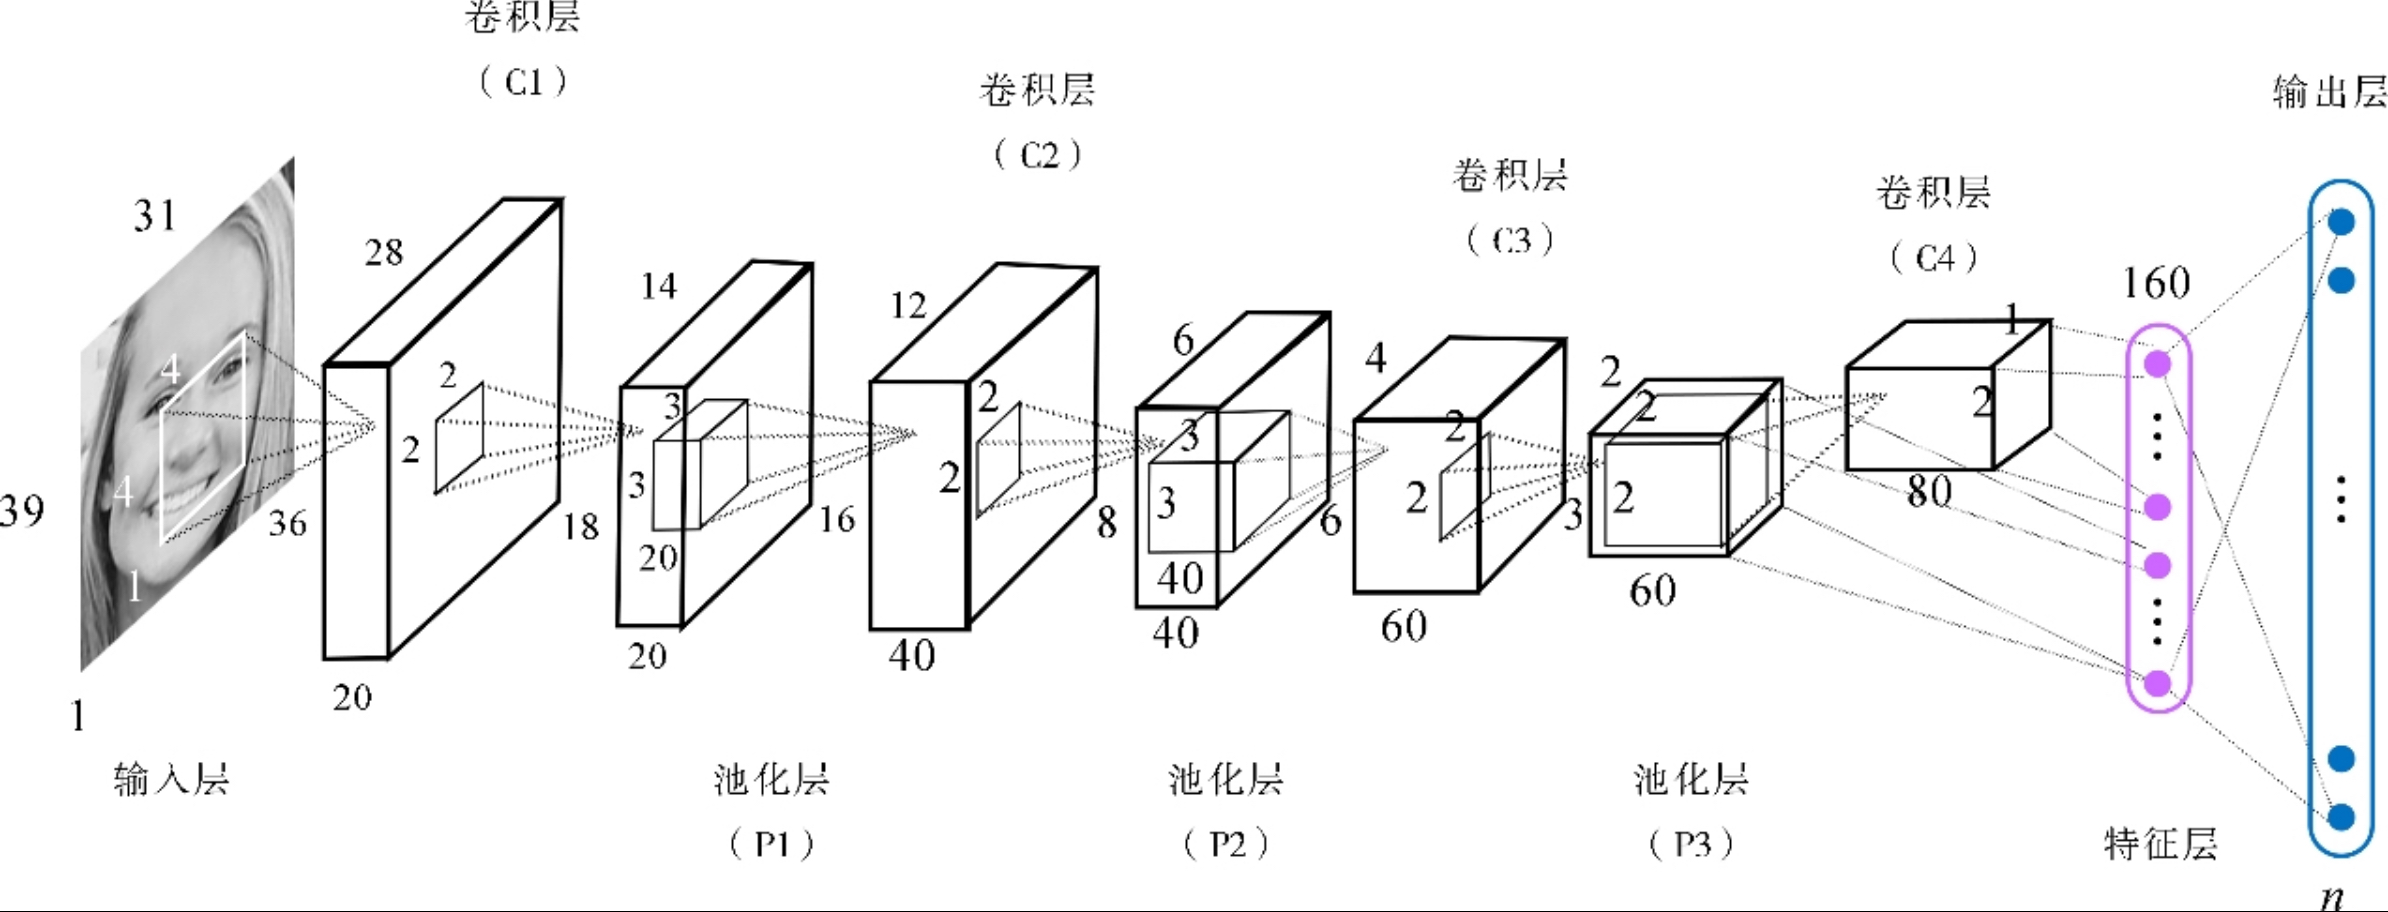

In [4]:
photo_path = '/content/drive/MyDrive/Colab Notebooks/convolutional neural network/1.jpg'

from IPython.display import Image
Image(filename=photo_path)

可以看到，卷积神经网络由若干个方块盒子构成，盒子从左到右仿佛越来越小，但越来越厚；最左边是一张图像，最右边则变成了两排圆圈。其实每一个方块都是由大量神经元构成的，只不过它们排成了立方体的形状。

**左边图象上的每个元素相当于一个神经元，构成了这个卷积神经网络的输入单元。**最右侧的圆圈也是神经元，它们排列成了两条直线，构成了该网络的输出。

卷积神经网络其实也是一种前馈神经网络，承载了深层的信息处理过程。信息从左侧输入，经过层层加工处理，最后从右侧输出。**对于图像分类任务而言，输入的是一张图像，历经一系列卷积层、池化层和完全连接层的运算，最终输出一组分类的概率，要分成多少类别，就有多少个输出神经元。**

相邻两层的神经元连接用上图中的小立体锥近似表示，实际上这种锥形遍布更高一层（右侧）立方体中的所有神经元。

**低层（左侧）到高层（右侧）的运算主要分为两大类：卷积和池化。一层卷积，一层池化，这两种运算交替进行，直到最后一层，我们又把立方体中的神经元拉平成了线性排列的神经元，与最后的输出层进行全连接。**